In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import make_blobs

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report, precision_score, roc_curve, auc

# Add docstrings to all functions!
# add note about why the loss_hist oscillates so much (because it is not batch gd or even mini-batch gd)
* [super helpful explanations of all types of gradient descent](https://am207.github.io/2017/wiki/gradientdescent.html#stochastic-gradient-descent)

In [39]:
X, y = make_blobs(n_samples=100, centers=2, n_features=2, random_state=3)
np.place(y, y==0, -1)

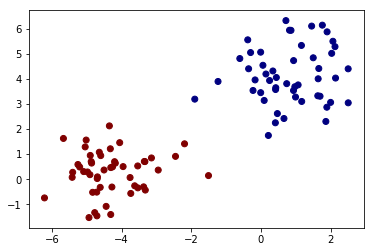

In [40]:
plt.scatter(X[:,0], X[:,1], c=y, cmap = 'jet')

In [41]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

---

In [42]:
def add_intercept(X):
    intercept = np.ones((X.shape[0], 1))
    return np.concatenate((intercept, X), axis=1)

In [52]:
X = add_intercept(X)

In [43]:
def hinge_loss(X_i, y_i, weights):
    loss = 1 - y_i * np.dot(weights.T, X_i)
    if loss < 0:
        loss = 0
    return loss

In [44]:
loss = []
for i in range(len(X)):
    loss.append(hinge_loss(X[i], y[i], w))
total_loss = np.sum(loss)
total_loss

100.0

In [45]:
w

array([ 0.,  0.])

In [53]:
learning_rate = 1
num_iters = 1000
w = np.zeros(len(X[0]))
# lambda = 1/iteration
loss_hist = []

def Stochastic_Gradient_Descent(X, y, learning_rate, num_iters):
    #X = add_intercept(X)
    weights = np.zeros(len(X[0]))
    for iteration in range(1, num_iters):
        for row in range(len(X)):
            loss = hinge_loss(X[row], y[row], weights)
            if loss == 0:
                weights = weights - learning_rate * ((2  * (1/iteration) * weights))
            else:
                weights = weights - learning_rate * ((-y[row] * X[row]) + (2  * (1/iteration) * weights))
    return weights
            

In [54]:
weights = Stochastic_Gradient_Descent(X = X, y=y, learning_rate=1, num_iters = 1000)

In [55]:
weights

array([  2.12889977e-03,  -3.55624119e+00,  -2.75181965e+00])

In [56]:
loss = []
for i in range(len(X)):
    loss.append(hinge_loss(X[i], y[i], weights))
total_loss = np.sum(loss)
total_loss

0

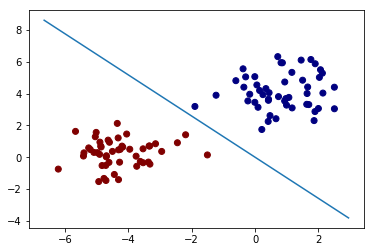

In [57]:
# it works, we've found the perfectly separating hyperplane!
plt.scatter(X[:,1], X[:,2], c=y, cmap = 'jet')
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx = np.linspace(xlim[0], xlim[1], 100)
plt.plot(xx, (-weights[1]/weights[2]) * xx - (weights[0]/weights[2]))

Text(0,0.5,'loss')

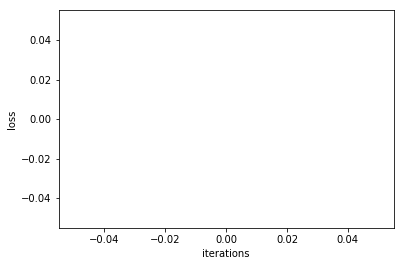

In [58]:
plt.plot(range(len(loss_hist)), loss_hist)
plt.xlabel('iterations')
plt.ylabel('loss')

In [59]:
min(loss_hist)

ValueError: min() arg is an empty sequence

## Now attempting to apply SVM from scratch to Crash data

In [64]:
X_cols = ['X', 'Y', 'DRIVER1AGE', 'NUMOFINJ', 'HOUR_X', 'HOUR_Y',
       'CRASHSEVER_Fatal', 'CRASHSEVER_Injury', 'DRIVER1SEX_M', 'DRIVER1SEX_U',
       'EMRGVEH_Yes', 'ALCOHOL_INVOLVED_Yes', 'MOTORCYCLE_Yes',
       'D1COND_Appeared Normal', 'D1COND_Fatigue / Sick']
y_cols = 'HITANDRUN_Yes'

In [76]:
crash_data = pd.read_csv('Data/Crash_data_prepared.csv')
X = crash_data.loc[:, X_cols]
y = crash_data.loc[:, y_cols]
y = y.replace(0,-1)

In [241]:
X = add_intercept(X)

# initialize weights
w = np.zeros(len(X[0]))

In [243]:
weights = Stochastic_Gradient_Descent(X = X, y=y, weights = w, learning_rate=1, num_iters = 100)

In [244]:
weights

array([ -6.09140074e-01,   1.04118923e+00,   7.07793204e-01,
         9.67768579e-01,   2.53899145e-01,   1.11069858e+00,
         1.67293522e+00,  -5.47032125e-38,  -3.11493419e-18,
        -1.58464931e+00,   1.10807531e+00,  -1.32293566e-03,
        -3.42052067e-01,  -2.67088006e-01,   1.88913836e-10,
        -1.21516932e+00,   7.94309784e-01])

In [245]:
loss = []
for i in range(len(X)):
    loss.append(hinge_loss(X[i], y[i], weights))
total_loss = np.sum(loss)
total_loss

array([ 52292.01078001])

In [258]:
def predict(X, weights):
    predictions = np.array([])
    for i in range(len(X)):
        dist_from_hyp = np.dot(X[i], weights)
        if dist_from_hyp > 0:
            predictions = np.append(predictions, 1)
        else:
            predictions = np.append(predictions, -1)
    return predictions

In [259]:
preds = predict(X, weights)

In [261]:
print(classification_report(y, preds))

             precision    recall  f1-score   support

         -1       0.83      0.93      0.88     57308
          1       0.55      0.31      0.39     15669

avg / total       0.77      0.80      0.77     72977



It is possible that with a stronger regularization term, I may achieve a higher precision! I should give this a go

In [262]:
tn, fp, fn, tp = confusion_matrix(y, preds).ravel()
print('True negatives:', tn)
print('True positives:', tp)
print('False negatives:', fn)
print('False Positives:', fp)

True negatives: 53433
True positives: 4783
False negatives: 10886
False Positives: 3875


---

---

---

## Statistical Re-sampling
Since the recall was still very low after training our SVM, we will use a statistical re-sampling technique designed for dealing with imbalanced classes, like ours. We'll be using some tools from the [imbalanced-learn package](http://contrib.scikit-learn.org/imbalanced-learn/stable/under_sampling.html)

In [88]:
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import AllKNN
from collections import Counter
from sklearn.svm import SVC

In [81]:
print(sorted(Counter(y).items()))

[(-1, 57308), (1, 15669)]


In [98]:
pipeline = make_pipeline(AllKNN(random_state=742),
                            SVC(kernel='linear'))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=742)

# Train the classifier with balancing
pipeline.fit(X_train, y_train)

# Test the classifier and get the prediction
y_pred = pipeline.predict(X_test)

In [95]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

         -1       0.90      0.90      0.90     14264
          1       0.65      0.66      0.65      3981

avg / total       0.85      0.85      0.85     18245



---

In [99]:
from imblearn.over_sampling import SMOTE

In [100]:
X_resampled, y_resampled = SMOTE().fit_sample(X, y)

In [102]:
print(sorted(Counter(y_resampled).items()))

[(-1, 57308), (1, 57308)]


In [101]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=742)

In [107]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [108]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

         -1       0.72      0.91      0.80     14187
          1       0.88      0.65      0.75     14467

avg / total       0.80      0.78      0.77     28654



In [106]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('True negatives:', tn)
print('True positives:', tp)
print('False negatives:', fn)
print('False Positives:', fp)

True negatives: 12794
True positives: 9400
False negatives: 5067
False Positives: 1393


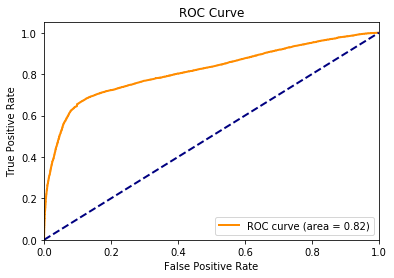

In [105]:
y_score = clf.decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()